In [1]:
import pandas as pd 
import numpy as np
import json
import requests
import os 
from os import makedirs
from os.path import join, exists
from datetime import date, timedelta

import re
import string
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer

import spacy
nlp = spacy.load("en_core_web_sm")

import matplotlib.pyplot as plt
import seaborn as sns
#sns.set_style('whitegrid')
%matplotlib inline

import warnings
warnings.simplefilter("ignore", DeprecationWarning)

from sklearn.decomposition import LatentDirichletAllocation as LDA
from pyLDAvis import sklearn as sklearn_lda
import pickle 
import pyLDAvis

from bokeh.io import output_file, show, output_notebook
from bokeh.models import ColumnDataSource
from bokeh.palettes import Category20b, cividis, inferno
from bokeh.plotting import figure
from bokeh.transform import factor_cmap

# Load Data 

In [2]:
articles_dir = "../Data/the_guardian_news/"

In [3]:
df = pd.read_csv(os.path.join(articles_dir,"df_guardian_nov14.csv"), index_col=0)

In [4]:
df.head(3)

,type,sectionId,sectionName,webPublicationDate,webTitle,webUrl,apiUrl,fields,isHosted,pillarId,pillarName,trailText,full_text,title_subtitle
id,,,,,,,,,,,,,,
society/2020/jan/18/expert-questions-effectiveness-airport-screening-new-coronavirus,article,society,Society,2020-01-18T19:20:36Z,Expert questions effectiveness of coronavirus ...,https://www.theguardian.com/society/2020/jan/1...,https://content.guardianapis.com/society/2020/...,{'headline': 'Expert questions effectiveness o...,False,pillar/news,News,We don’t know enough yet to be sure of catchin...,Medical staff at airports trying to screen for...,Expert questions effectiveness of coronavirus ...
world/2020/jan/18/no-airport-screening-for-new-sars-like-virus-yet-china,article,world,World news,2020-01-18T19:20:36Z,No screening for new Sars-like virus at UK air...,https://www.theguardian.com/world/2020/jan/18/...,https://content.guardianapis.com/world/2020/ja...,{'headline': 'No screening for new Sars-like v...,False,pillar/news,News,Experts decide no need for checks as member of...,Health officials have ruled out introducing sc...,No screening for new Sars-like virus at UK air...
world/2020/jan/18/coronavirus-what-airport-measures-are-in-place-to-detect-for-sick-passengers,article,world,World news,2020-01-18T09:21:23Z,Coronavirus: what airport measures are in plac...,https://www.theguardian.com/world/2020/jan/18/...,https://content.guardianapis.com/world/2020/ja...,{'headline': 'Coronavirus: what airport measur...,False,pillar/news,News,"Three US airports introduce screening, followi...",International airports are stepping up screeni...,Coronavirus: what airport measures are in plac...


## Data cleaning and pre-processing

Bag of words

In [5]:
def text_to_bow(text):
    '''
    convert text to just lowercase words
    '''
    # optional if dealing with strings which might contain nan 
    if text == np.nan:
        return text 
    else: 
        text = str(text).lower()
        text = re.sub('\n', ' ', text) 
        text = re.sub('<br>', ' ', text) 
        # remove non alphanumeric characters
        regex = re.compile('[^0-9a-zA-Z- ]')
        text = regex.sub('', text)
        text = re.sub(' +', ' ', text).strip()
        return text

In [6]:
df['title_subtitle_bow'] = df['title_subtitle'].apply(lambda x : text_to_bow(x))

Lemmatized bag of words

In [7]:
def spacy_lemmatize(text_list):
    lemmatized_text = []
    for text in text_list:
        doc = nlp(text_to_bow(text))
        doc_tokens = []
        for token in doc:
            if token.is_stop == False:
                doc_tokens.append(token.lemma_)
        lemmatized_text.append(" ".join(doc_tokens))
    return lemmatized_text

In [8]:
df['title_subtitle_lem'] = spacy_lemmatize(df['title_subtitle'])

In [9]:
df = pd.read_csv("resources/df_guardian_lem_nov14.csv", index_col=0)

In [10]:
df["date"] = pd.to_datetime(df["webPublicationDate"].apply(lambda x : x.split("T")[0]))

In [11]:
df.head(3)

,type,sectionId,sectionName,webPublicationDate,webTitle,webUrl,apiUrl,fields,isHosted,pillarId,pillarName,trailText,full_text,title_subtitle,title_subtitle_bow,title_subtitle_lem,date
id,,,,,,,,,,,,,,,,,
society/2020/jan/18/expert-questions-effectiveness-airport-screening-new-coronavirus,article,society,Society,2020-01-18T19:20:36Z,Expert questions effectiveness of coronavirus ...,https://www.theguardian.com/society/2020/jan/1...,https://content.guardianapis.com/society/2020/...,{'headline': 'Expert questions effectiveness o...,False,pillar/news,News,We don’t know enough yet to be sure of catchin...,Medical staff at airports trying to screen for...,Expert questions effectiveness of coronavirus ...,expert questions effectiveness of coronavirus ...,expert question effectiveness coronavirus airp...,2020-01-18
world/2020/jan/18/no-airport-screening-for-new-sars-like-virus-yet-china,article,world,World news,2020-01-18T19:20:36Z,No screening for new Sars-like virus at UK air...,https://www.theguardian.com/world/2020/jan/18/...,https://content.guardianapis.com/world/2020/ja...,{'headline': 'No screening for new Sars-like v...,False,pillar/news,News,Experts decide no need for checks as member of...,Health officials have ruled out introducing sc...,No screening for new Sars-like virus at UK air...,no screening for new sars-like virus at uk air...,screening new sars - like virus uk airport exp...,2020-01-18
world/2020/jan/18/coronavirus-what-airport-measures-are-in-place-to-detect-for-sick-passengers,article,world,World news,2020-01-18T09:21:23Z,Coronavirus: what airport measures are in plac...,https://www.theguardian.com/world/2020/jan/18/...,https://content.guardianapis.com/world/2020/ja...,{'headline': 'Coronavirus: what airport measur...,False,pillar/news,News,"Three US airports introduce screening, followi...",International airports are stepping up screeni...,Coronavirus: what airport measures are in plac...,coronavirus what airport measures are in place...,coronavirus airport measure place detect sick ...,2020-01-18


# Inspect data 

### Variability of news per day over time

In [12]:
num_artlces_per_day = df.groupby("date")['webTitle'].count()

(<Figure size 1440x1440 with 1 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe5c3568150>],
       dtype=object))

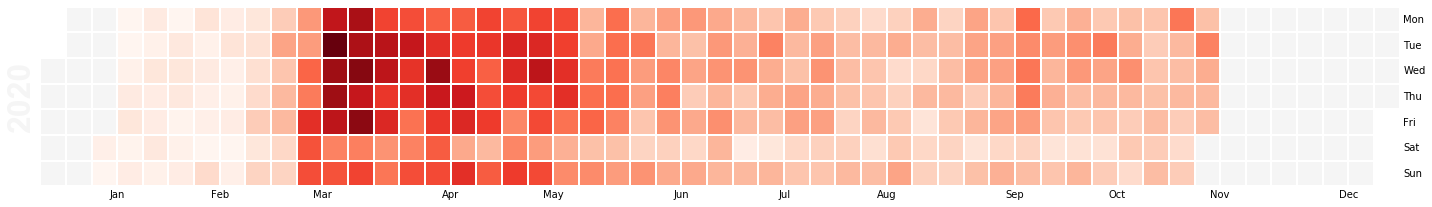

In [13]:
import calmap
calmap.calendarplot(num_artlces_per_day, fig_kws=dict(figsize=(20, 20)))

# Bag of Words
Note: To get the equivalent for Tfidf, just replace the CountVectorizer with TfidfVectorizer from sklearn

In [14]:
class BagOfWords:
    def __init__(self, data, max_df, min_df, stop_words, ngram_range):
        self.data = data
        self.max_df = max_df 
        self.min_df = min_df 
        self.stop_words = stop_words 
        self.ngram_range = ngram_range 
        self.MyCountVectorizer = CountVectorizer(
            max_df=self.max_df, 
            min_df=self.min_df, 
            stop_words=self.stop_words, 
            ngram_range=self.ngram_range)
        # init the empty vars 
        self.X = ""
        self.feature_names = ""
        self.counts = ""
        self.df_counts = ""
        self.dict_counts = ""
        self.wordcloud = ""
        self.p = ""
        
        
    #fit the count vectorizer 
    def fit_transform(self):
        self.X = self.MyCountVectorizer.fit_transform(self.data)
        
    def get_feature_names(self):
        self.feature_names = self.MyCountVectorizer.get_feature_names()
        
    def get_bow_feature_counts(self): 
        self.counts = self.X.toarray().sum(axis=0)
        # create a df with feature names and counts 
        self.df_counts = pd.DataFrame({"feature_names": self.feature_names, "counts": self.counts}).sort_values(by="counts", ascending=False)
    
    # get the data into a dict format of {word: freq} type to feed into the wordcloud 
    def prep_for_wordcloud(self):
        _dict_counts = self.df_counts.set_index("feature_names").to_dict(orient="index")
        self.dict_counts = {}
        for keyword, count in _dict_counts.items():
            self.dict_counts[keyword] = count['counts']
    
    # visualise the word cloud
    def viz_wordcloud(self, background_color="black", max_words=200, width=700, height=400):
        self.wordcloud = WordCloud(background_color=background_color, max_words=max_words, width=width, height=height)
        self.wordcloud.generate_from_frequencies(self.dict_counts)
        #self.wordcloud.to_image()
        
    # bar chart of word frequencies 
    def barchart_wordfreq(self, 
                          num_top_features=30,
                          output_here=True, save_filename="plot", 
                          plot_height=350, plot_width=800, title="Title", bgcolor = "#2b2b2b"):
        
        counted_data = self.df_counts.nlargest(num_top_features, "counts")["feature_names"].tolist()
        counts = self.df_counts.nlargest(num_top_features, "counts")["counts"].tolist()
        # either display in the notebook or save file 
        if output_here:
            output_notebook()
        else:
            output_file(save_filename+".html")
        
        source = ColumnDataSource(data=dict(counted_data=counted_data, counts=counts))
        self.p = figure(x_range=counted_data, plot_height=plot_height, plot_width=plot_width, toolbar_location=None, title=title)
    
        self.p.vbar(x='counted_data',
           top='counts', 
           width=0.8, 
           source=source, 
           line_color='white', 
           fill_color=factor_cmap('counted_data', palette=cividis(len(counted_data)), factors=counted_data))
    
        self.p.xgrid.grid_line_color = None
        self.p.ygrid.grid_line_color = None
        self.p.y_range.start = 0
        self.p.xaxis.major_label_orientation = 1.2
        #p.y_range.end = 5000
        self.p.background_fill_color = bgcolor
    
        show(self.p)

### 1-grams with the bow data 

In [15]:
# initialize the count vectorizer 
bow = BagOfWords(data=df['title_subtitle_bow'], max_df=0.99, min_df=0.005, stop_words="english", ngram_range=(1, 1))
# fit transform and get the fit-transformed matrix of word frequencies
bow.fit_transform() #bow_bow.X
# get the feature names 
bow.get_feature_names() #bow.feature_names
# get the feature counts 
bow.get_bow_feature_counts() #bow.df_counts

In [16]:
print("Number of features: {}".format(len(bow.feature_names)))

Number of features: 619


In [17]:
bow.df_counts.head(5)

,feature_names,counts
108,coronavirus,3455
566,uk,2646
113,covid,2370
469,says,1633
3,19,1516


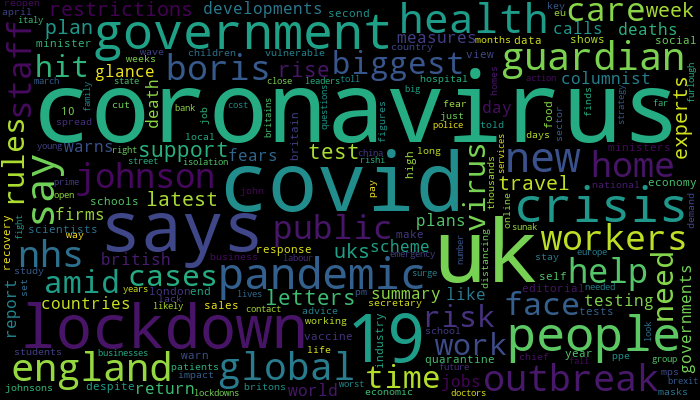

In [18]:
# wordcloud 
bow.prep_for_wordcloud()
bow.viz_wordcloud()
bow.wordcloud.to_image()

In [19]:
bow.barchart_wordfreq(num_top_features=50, plot_width=1000)
#show(bow.p)

Loading BokehJS ...

### 1 grams with the lem data

In [20]:
# initialize the count vectorizer 
bow_lem = BagOfWords(data=df['title_subtitle_lem'], max_df=0.99, min_df=0.005, stop_words="english", ngram_range=(1, 1))
# fit transform and get the fit-transformed matrix of word frequencies
bow_lem.fit_transform() #bow_bow.X
# get the feature names 
bow_lem.get_feature_names() #bow.feature_names
# get the feature counts 
bow_lem.get_bow_feature_counts() #bow.df_counts

### 1 and 2 grams with bow data 

In [21]:
# initialize the count vectorizer 
bow_ngrams = BagOfWords(data=df['title_subtitle_bow'], max_df=0.99, min_df=0.001, stop_words="english", ngram_range=(1, 2))
# fit transform and get the fit-transformed matrix of word frequencies
bow_ngrams.fit_transform() #bow_bow.X
# get the feature names 
bow_ngrams.get_feature_names() #bow.feature_names
# get the feature counts 
bow_ngrams.get_bow_feature_counts() #bow.df_counts

In [22]:
print("Number of features: {}".format(len(bow_ngrams.feature_names)))

Number of features: 3514


In [23]:
bow_ngrams.df_counts.head(5)

,feature_names,counts
687,coronavirus,3455
3239,uk,2646
756,covid,2370
2688,says,1633
27,19,1516


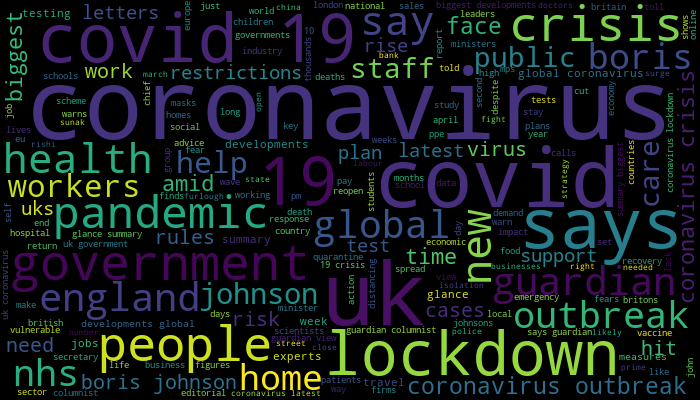

In [24]:
# wordcloud 
bow_ngrams.prep_for_wordcloud()
bow_ngrams.viz_wordcloud()
bow_ngrams.wordcloud.to_image()

In [25]:
bow_ngrams.barchart_wordfreq(num_top_features=50, plot_width=1000)

Loading BokehJS ...

### bigrams with bow data

In [26]:
# initialize the count vectorizer 
bow_2grams = BagOfWords(data=df['title_subtitle_bow'], max_df=0.99, min_df=0.001, stop_words="english", ngram_range=(2, 2))
# fit transform and get the fit-transformed matrix of word frequencies
bow_2grams.fit_transform() #bow_bow.X
# get the feature names 
bow_2grams.get_feature_names() #bow.feature_names
# get the feature counts 
bow_2grams.get_bow_feature_counts() #bow.df_counts

In [27]:
bow_2grams.df_counts.head(5)

,feature_names,counts
140,covid 19,1494
115,coronavirus outbreak,323
98,coronavirus crisis,272
48,boris johnson,265
245,global coronavirus,225


In [28]:
#bow_2grams.barchart_wordfreq(num_top_features=50, plot_width=1000)

Note: it is better to look at the most common noun phrases rather than the bigrams as there is a lot of noise here 

# Topic modelling with LDA

In [29]:
# pass in the bow data and the vectorizer that was used to obtain in 
class TopicModelling:
    def __init__(self, bow_data, vectorizer, n_components, n_top_words):
        self.bow_data = bow_data
        self.n_components = n_components 
        self.n_top_words = n_top_words
        self.vectorizer = vectorizer
        self.lda = LDA(n_components=n_components, 
                                max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
        self.feature_names = ""
        self.top_topic_words = {}
        
    def fit(self):
        self.lda.fit(self.bow_data)
        
    # get the features from the passed vectorizer
    def get_feature_names(self):
        self.feature_names = self.vectorizer.get_feature_names()
       
    def get_top_topic_words(self):
        for topic_idx, topic in enumerate(self.lda.components_):
            self.top_topic_words["topic_" + str(topic_idx)] = " ".join([self.feature_names[i] for i in topic.argsort()[:-self.n_top_words - 1:-1]])
            
    # predic the topics 
    def pred(self, data):
        return self.lda.transform(data)
    
    # make a dataframe out of the predictions 
    def preds_to_df(self, data):
        preds = self.pred(data)
        preds_df = pd.DataFrame(preds)
        preds_df.columns = ["topic_" + str(i) for i in preds_df.columns.tolist()]
        return preds_df
    
    def visualise_lda(self, data, filename="lda_visualised"):
        LDAvis_prepared = sklearn_lda.prepare(self.lda, data, self.vectorizer)
        pyLDAvis.save_html(LDAvis_prepared, os.path.join(filename + '.html'))
    

In [30]:
def get_lda(vectorized_data=bow_lem.X, data_vectorizer=bow_lem.MyCountVectorizer, n_components=10, n_top_words=20, filename="resources/bow_lem_"):
    
    lda = TopicModelling(bow_data=vectorized_data, vectorizer=data_vectorizer, n_components=n_components, n_top_words=n_top_words)
    # fit the lda model 
    lda.fit()
    # get the vectorizer feature names 
    lda.get_feature_names()
    # get the top words for each topic 
    lda.get_top_topic_words()
    print(lda.top_topic_words)
    
    lda_preds = lda.pred(vectorized_data)
    preds_df = lda.preds_to_df(vectorized_data)
    
    lda.visualise_lda(vectorized_data, filename+str(n_components))
    
    # join the preds to the original data and inspect the topics
    df_lda = df.reset_index().join(preds_df).set_index("id")
    # inspect the data 
    #df_lda.nlargest(10, "topic_6")['title_subtitle'].tolist()
    return lda, lda_preds, preds_df, df_lda

#### 5 topics

In [31]:
lda5, lda_preds5, preds_df5, df_lda5 = get_lda(n_components=5)

{'topic_0': 'covid uk 19 say coronavirus test health government death nhs people public vaccine expert risk scientist testing minister lead second', 'topic_1': 'uk coronavirus covid lockdown crisis 19 letter amid job people hit pandemic travel help like cut pay firm say fear', 'topic_2': 'coronavirus outbreak global big development late glance summary world hospital case die 19 fight europe covid economic rise april country', 'topic_3': 'say guardian coronavirus johnson boris government uk covid business plan pandemic crisis columnist need view britain lockdown minister scheme school', 'topic_4': 'lockdown coronavirus uk england people covid home say care face worker rule warn mask social bank new leave student life'}


#### 10 topics

In [32]:
lda10, lda_preds10, preds_df10, df_lda10 = get_lda(n_components=10)

{'topic_0': 'uk scheme government say quarantine plan end coronavirus sunak rule furlough chancellor travel warn job support rishi policy covid list', 'topic_1': 'covid 19 uk coronavirus say amid crisis self sale lockdown health pay claim isolate raise issue level ban rise pandemic', 'topic_2': 'coronavirus outbreak global big late development glance summary april isolation march think review panic immunity june news explain 19 update', 'topic_3': 'johnson lockdown boris minister england school say reopen coronavirus plan ease return restriction pm new rule tory prime uk government', 'topic_4': 'home care coronavirus uk worker lockdown people social london student life child leave family police say staff thousand university city', 'topic_5': 'covid 19 test coronavirus uk nhs say letter health government people hospital die scientist patient doctor testing expert trace chief', 'topic_6': 'guardian face covid say 19 crisis britain view columnist coronavirus pandemic mask food time need e

In [33]:
df_lda10.nlargest(10, "topic_6")['title_subtitle'].tolist()

["'I find myself spiralling': the crisis facing British music venues. Venues in the UK are preparing to open their doors again. But as owners from arenas to tiny clubs explain, the danger is far from over",
 'The Guardian view on arts freelancers: they must not be forgotten | Editorial. <strong>Editorial:</strong> The government has stepped in to protect the UK’s cultural infrastructure, but has neglected the people who make the art',
 "No-deal Brexit 'would overwhelm local emergency teams'. Leaked report warns local disaster planning already exhausted by coronavirus crisis",
 "The horror of coronavirus is all too real. Don't turn it into an imaginary war | Marina Hyde. Politicians may turn to platitudes about heroes or battlers or victories, but they can’t disguise Britain’s grim current reality, says Guardian columnist Marina Hyde",
 'Almost 2,000 tags bought for UK Covid-19 prisoner releases remain unused. Justice ministry said up to 4,000 inmates would be freed but so far only 57 h

#### 15 topics

In [34]:
lda15, lda_preds15, preds_df15, df_lda15 = get_lda(n_components=15)

{'topic_0': 'travel quarantine uks long covid ban app policy air list day testing 19 cumming dominic mass vital effect country term', 'topic_1': 'uk coronavirus self crisis plan government support sunak claim action isolate chancellor set rishi theatre say pay fund amid help', 'topic_2': 'coronavirus outbreak big global development late glance summary april financial news march launch project chinese june 30 20 12 14', 'topic_3': 'school uk reopen lockdown child job close struggle loss reveal scheme warn furlough end group study risk open coronavirus plan', 'topic_4': 'care home worker coronavirus social uk student key warn need cost thousand lockdown face family save use government police university', 'topic_5': 'test health letter nhs covid uk 19 staff say coronavirus doctor government secretary trace ppe hospital strongletter hancock lack testing', 'topic_6': 'tell work british return local uk eu mps coronavirus turn home office party people test official say stay positive centre', 

#### 20 topics

In [48]:
lda20, lda_preds20, preds_df20, df_lda20 = get_lda(n_components=20)

{'topic_0': 'johnson boris national pm minister john like lockdown prime coronavirus return tory hold johnsons experience learn follow avoid crace release', 'topic_1': 'uk coronavirus travel pay quarantine self holiday briton isolate company flight list country cancel air end france plan government firm', 'topic_2': 'report good consider distance supply shopper march coronavirus rule global soar message uk stop outbreak mask threaten big half want', 'topic_3': 'scheme uk firm secretary nhs coronavirus help furlough reveal loan staff hancock business ppe health matt shortage small game survey', 'topic_4': 'care social home london run city coronavirus hospital centre ask england say funding council north sport free promise west author', 'topic_5': 'letter coronavirus contact theatre isolation app crisis strongletter uk live write mental people debt far art health venue music film', 'topic_6': 'home face food stay street family office offer mask turn restaurant pub open meet shop staff re

# Spacy features

## Part of speech 
- Counting the number of nouns, noun phrases, verbs, adjectives etc

In [55]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [56]:
wanted_pos = ['PROPN', "VERB", "NOUN", "ADV", "ADJ"]

Utility functions 

In [57]:
# for a single string of text, return a list of the words of the desired pos type
# and a list of the corresponding lemmas 
def collect_pos(pos, text, stopword=False):
    pos_text = []
    pos_lemma = []
    doc = nlp(text)
    for token in doc:
        if token.pos_ == pos and token.is_stop == False:
            pos_text.append(token.text)
            pos_lemma.append(token.lemma_)
    return pos_text, pos_lemma

In [58]:
def collect_noun_chunks(text):
    noun_chunks = []
    doc = nlp(text)
    for chunk in doc.noun_chunks:
        noun_chunks.append(chunk.text)
    return noun_chunks

#### noun chunks

In [59]:
noun_chunks = []
for text in df["title_subtitle_bow"].tolist():
    noun_chunks.extend(collect_noun_chunks(text))
noun_chunks_counts = pd.Series(noun_chunks).value_counts()

In [60]:
noun_chunks_counts.head(20)

coronavirus                        1317
it                                  673
uk                                  604
we                                  603
who                                 402
they                                393
covid-19                            371
what                                328
people                              327
lockdown                            304
i                                   289
england                             281
you                                 261
the uk                              258
us                                  243
a glance                            222
the global coronavirus outbreak     217
the biggest developments            214
a summary                           205
boris johnson                       178
dtype: int64

### visualising pos frequecies 
over the entire corpus. 

In [61]:
def collect_pos(text):
    doc = nlp(text)
    nouns, verbs, adverbs, adjectives, other_pos = [], [], [], [], []
    for token in doc: 
        if token.pos_ == "NOUN" or token.pos_ == "PROPN":
            nouns.append(token.lemma_)
        elif token.pos_ == "VERB":
            verbs.append(token.lemma_)
        elif token.pos_ == "ADV":
            adverbs.append(token.lemma_)
        elif token.pos_ == "ADJ":
            adjectives.append(token.lemma_)
        else:
            other_pos.append(token.text)
    return nouns, verbs, adverbs, adjectives, other_pos

In [62]:
nouns_all, verbs_all, adverbs_all, adjectives_all, other_pos_all =  [], [], [], [], []
for text in df['title_subtitle_bow'].tolist():
    nouns, verbs, adverbs, adjectives, other_pos = collect_pos(text)
    nouns_all.extend(nouns)
    verbs_all.extend(verbs)
    adverbs_all.extend(adverbs)
    adjectives_all.extend(adjectives)
    other_pos_all.extend(other_pos)

In [63]:
len(nouns_all)

87324

In [64]:
all_pos = {}
all_pos['nouns'] = len(nouns_all)
all_pos['verbs'] = len(verbs_all)
all_pos['adverbs'] = len(adverbs_all)
all_pos['adjectives'] = len(adjectives_all)

In [65]:
all_pos

{'nouns': 87324, 'verbs': 34090, 'adverbs': 6339, 'adjectives': 18165}

In [66]:
from bokeh.io import output_file, show
from bokeh.palettes import Category20c, cividis
from bokeh.plotting import figure
from bokeh.transform import cumsum
from math import pi

In [67]:
data_viz = pd.DataFrame.from_dict(all_pos, orient="index").reset_index()
data_viz.columns = ['pos', 'value']

In [68]:
#data = pd.DataFrame({"pos": ["nouns", "verbs"], "value" : [len(all_nouns), len(all_verbs)]})
data_viz['angle'] = data_viz['value']/data_viz['value'].sum() * 2*pi
data_viz['color'] = cividis(4)

p = figure(plot_height=350, title="Frequency of each pos type", toolbar_location=None,
           tools="hover", tooltips="@pos: @value", x_range=(-0.5, 1.0))

p.wedge(x=0, y=1, radius=0.4,
        start_angle=cumsum('angle', include_zero=True), end_angle=cumsum('angle'),
        line_color="white", fill_color='color', legend_field='pos', source=data_viz)

p.axis.axis_label=None
p.axis.visible=False
p.grid.grid_line_color = None

show(p)

## Named Enetity Recognition 

### visualising named entities 

In [69]:
from spacy import displacy
text = df['title_subtitle'].tolist()[3703]
doc = nlp(text)
displacy.serve(doc, style="ent")

/Users/dea/opt/anaconda3/lib/python3.7/site-packages/spacy/displacy/__init__.py:94: UserWarning: [W011] It looks like you're calling displacy.serve from within a Jupyter notebook or a similar environment. This likely means you're already running a local web server, so there's no need to make displaCy start another one. Instead, you should be able to replace displacy.serve with displacy.render to show the visualization.
  warnings.warn(Warnings.W011)



Using the 'ent' visualizer
Serving on http://0.0.0.0:5000 ...

Shutting down server on port 5000.


In [78]:
def get_all_entities(text_series, text_field):
    df_ents_all = []
    for text, index in zip(text_series[text_field], text_series[text_field].index):
        doc = nlp(text)
        ents = [(e.text, e.start_char, e.end_char, e.label_) for e in doc.ents]
        df_ents = pd.DataFrame(ents)
        df_ents['index'] = index
        df_ents['text'] = text 
        df_ents_all.append(df_ents)
    df_ents_all= pd.concat(df_ents_all)
    df_ents_all.columns = ["entity", "start_pos", "end_pos", "type", "index", "text"]
    return df_ents_all

In [79]:
df_ents_all = get_all_entities(df, 'title_subtitle')

In [80]:
df_ents_all.head()

,entity,start_pos,end_pos,type,index,text
0,Wellcome Trust,139.0,153.0,ORG,society/2020/jan/18/expert-questions-effective...,Expert questions effectiveness of coronavirus ...
0,UK,40.0,42.0,GPE,world/2020/jan/18/no-airport-screening-for-new...,No screening for new Sars-like virus at UK air...
1,Coronavirus,106.0,117.0,PERSON,world/2020/jan/18/no-airport-screening-for-new...,No screening for new Sars-like virus at UK air...
2,"1,700",139.0,144.0,CARDINAL,world/2020/jan/18/no-airport-screening-for-new...,No screening for new Sars-like virus at UK air...
3,China,148.0,153.0,GPE,world/2020/jan/18/no-airport-screening-for-new...,No screening for new Sars-like virus at UK air...


### visualise most common entities per category

In [81]:
porg = df_ents_all.groupby("entity").nunique()[['text']]
porg.columns =['num']
porg = porg.sort_values(by='num', ascending=False).head(200)

In [82]:
df_ents_top = porg.join(df_ents_all.drop_duplicates(subset=['entity'])[['entity', 'type']].set_index("entity")).reset_index()

In [83]:
df_ents_top

,entity,num,type
0,UK,2669,GPE
1,Covid,534,PERSON
2,England,444,GPE
3,Guardian,432,ORG
4,Boris Johnson,305,PERSON
...,...,...,...
195,VAT,11,ORG
196,today,11,DATE
197,Home Office,11,ORG
198,Neil Ferguson,11,PERSON


In [84]:
df_ent= df_ents_top[1:].copy()
group_ent = df_ent.groupby(['type', 'entity'])
index_cmap_ent = factor_cmap('type_entity', 
                             palette=cividis(len(df_ents_top["type"].unique())), 
                             factors=df_ents_top["type"].unique(), end=1)

In [85]:
p = figure(plot_width=2200, plot_height=600, title="Most frequent named entities per category",
           x_range=group_ent, toolbar_location=None,
          tooltips=[("Num", "@num_mean"), ("Entity type, entity", "@type_entity")])

p.vbar(x='type_entity', top='num_mean', width=1, source=group_ent,
       line_color="white", fill_color=index_cmap_ent, )

p.y_range.start = 0
p.x_range.range_padding = 0.05
p.xgrid.grid_line_color = None
p.xaxis.axis_label = "Most common entities by type"
p.xaxis.major_label_orientation = 1.5
p.outline_line_color = None
p.background_fill_color = "#2b2b2b"

show(p)

# Sentimenet Analysis 

### Google NLP Sentiment Analysis API

In [132]:
from google.cloud import language_v1
from google.cloud.language_v1 import enums

In [18]:
def analyze_sentiment(text, language="en"):
    client = language_v1.LanguageServiceClient()
    type_ = enums.Document.Type.PLAIN_TEXT

    document = {"content": text, "type": type_, "language": language}

    encoding_type = enums.EncodingType.UTF8

    response = client.analyze_sentiment(document, encoding_type=encoding_type)

    return response.document_sentiment.score

In [93]:
df1000 = df.sample(n=1000)
df1000['sentiment'] = df1000['title_subtitle'].apply(lambda x : analyze_sentiment(x))
df1000.to_csv('df1000.csv')

In [19]:
df2500 = df.sample(n=2500)
#df2500['sentiment'] = df2500['title_subtitle'].apply(lambda x : analyze_sentiment(x))

In [134]:
df1000 = pd.read_csv("df1000.csv", index_col=0)

### Transformers Sentiment Analysis

In [133]:
from transformers import pipeline
nlp = pipeline("sentiment-analysis")

Sample data 

In [135]:
labels = []
scores = []
for article in df1000['title_subtitle']:
    result = nlp(article)[0]
    labels.append(result['label'])
    scores.append(round(result['score'], 4))

In [136]:
df1000['transformers_sentiment'] = scores
df1000['transformers_label'] = labels

All the data 

In [137]:
labels = []
scores = []
for article in df['title_subtitle']:
    result = nlp(article)[0]
    labels.append(result['label'])
    scores.append(round(result['score'], 4))

In [138]:
df['transformers_sentiment'] = scores
df['transformers_label'] = labels

In [139]:
transformer_sentiment_posneg = []
for label, sentiement in zip(df['transformers_label'], df['transformers_sentiment']):
    if label =='NEGATIVE':
        transformer_sentiment_posneg.append(- sentiement)
    else: 
        transformer_sentiment_posneg.append(sentiement)
        

In [140]:
df["transformer_sentiment_posneg"] = transformer_sentiment_posneg

(<Figure size 1440x1440 with 1 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ffa6842ed50>],
       dtype=object))

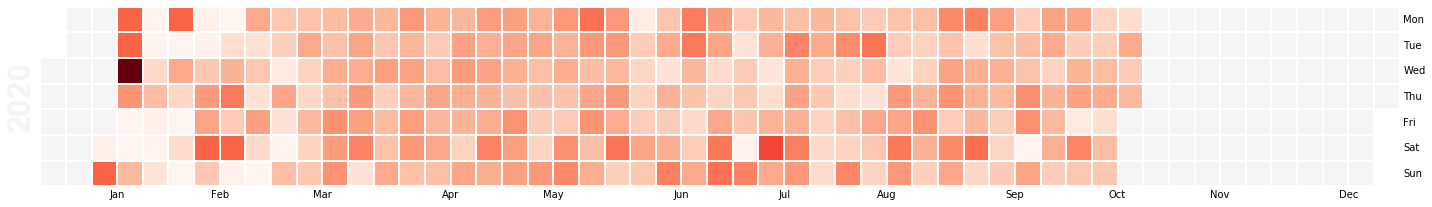

In [141]:
df["date"] = pd.to_datetime(df["date"])
avg_sentiment_per_day = df.groupby("date")['transformer_sentiment_posneg'].mean()
calmap.calendarplot(avg_sentiment_per_day, fig_kws=dict(figsize=(20, 20)))

In [142]:
df[df["transformers_label"]=='POSITIVE'].nlargest(20, "transformers_sentiment")['webTitle'].tolist()

["'It’s crazy good': Covid boom leaves UK furniture firms sitting pretty",
 'Guardian to spotlight dazzling unstaged scripts in a new series',
 'From standup to the Sistine chapel: the best online culture for self-isolation',
 'Hottest front-room seats: the best theatre and dance to watch online',
 'Tell us about the community projects bringing joy',
 'The Well Gardened Mind by Sue Stuart-Smith; The Natural Health Service by Isabel Hardman – review',
 'Patient, amusing, inspirational... teachers have always made a difference',
 'Share your tributes and memories of UK coronavirus victims who died during the summer',
 'We will only beat coronavirus if cities  around the world pull together | Sadiq Khan',
 "United Voices: an inspiring story of workers' grassroots resistance",
 '‘The wondrous map’: how unlocking human DNA changed the course of science',
 'This Europe Day we send a message of solidarity and friendship to British people',
 'Locksdown: readers share their home haircut adventu

In [143]:
df[df["transformers_label"]=='NEGATIVE'].nlargest(20, "transformers_sentiment")['webTitle'].tolist()

["People in England's 10 worst-hit Covid-19 hotspots unable to get tests",
 'Shopping centre owner Intu collapses into administration',
 'MoJ failed to investigate potential Covid-19 cluster among cleaners',
 'UK bars and hair salons get more help than care homes, say providers',
 "Fast fashion creates misery, and that's a bad look | Bidisha",
 'Analysts and investors lose their bearings in the coronavirus fallout | Nils Pratley',
 'British public demands more information on coronavirus cases',
 'More than £1bn wiped off Boohoo value as it investigates Leicester factory',
 'I am a swab tester – but we have barely any swabs to test | Gianmarco Raddi',
 'Covid-19: did the UK government prepare for the wrong kind of pandemic?',
 "Bank of England warns mass return to UK offices 'not possible'",
 "'It's the worst I've ever seen': London’s West End struggles to bounce back",
 "Rishi Sunak's furlough support scheme fails to reassure Britons",
 'Airbus slows plane-making as Covid-19 leads to £

### compariason

In [35]:
df1000[df1000["transformers_label"]=='POSITIVE'].nlargest(10, "transformers_sentiment")['webTitle'].tolist()

["‘It's so good to be back’: Jay Rayner’s first restaurant meal since lockdown",
 'After-work drinks by video: how to survive 100 days of solitude',
 'Amid the cruelty of the pandemic, this weekend offers a glimmer of hope | Jonathan Freedland',
 "Morrisons CEO: 'Our people are the new rock stars'",
 'Share your tributes and memories of UK coronavirus victims',
 "'It's lovely to be here': county cricket fans return to the Oval",
 'How to enjoy birthdays and romantic dinners in lockdown',
 'Green and pleasant beats urban buzz as families opt to leave cities',
 "'This is a scary time': coronavirus emergency fund set up for authors",
 'Home school competition celebrates black British history']

In [105]:
df1000.nlargest(10, "sentiment")['webTitle'].tolist()

["‘It's so good to be back’: Jay Rayner’s first restaurant meal since lockdown",
 'Weird and wonderful ways to get through the Covid-19 lockdown',
 "'You won’t be left on your own': expert tips for freshers on studying at home",
 'Student finance: everything you need to be ready for university',
 'Chancellor makes £30bn budget pledge to protect economy from coronavirus',
 'How to enjoy birthdays and romantic dinners in lockdown',
 'Green and pleasant beats urban buzz as families opt to leave cities',
 'Europe’s big two kiss and make up for pandemic rescue deal',
 'Spanish hotel group to offer guests free Covid testing',
 "'It's lovely to be here': county cricket fans return to the Oval"]

In [30]:
df1000[df1000["transformers_label"]=='NEGATIVE'].nlargest(10, "transformers_sentiment")['webTitle'].tolist()

['Boris fails to convince with sanitised take on coronavirus | John Crace',
 'Makers of M&S sandwiches faced pay dock if they self-isolated, says union',
 'MoJ failed to investigate potential Covid-19 cluster among cleaners',
 "Fast fashion creates misery, and that's a bad look | Bidisha",
 'More than £1bn wiped off Boohoo value as it investigates Leicester factory',
 'Why is there a delay in sharing Covid-19 test data with English councils?',
 "Bank of England warns mass return to UK offices 'not possible'",
 'Panic buying sweeps stores despite appeal for responsible shopping',
 "What's missing from the chancellor's new scheme to save jobs?",
 "Britain's failure to learn the hard lessons of its first Covid surge is a disaster | William Hanage"]

In [106]:
df1000.nsmallest(10, "sentiment")['webTitle'].tolist()

['Matt Hancock accused of blaming public for Covid test shortages',
 "'Not fit for purpose': UK medics condemn Covid-19 protection",
 'Sinister immigration bill makes me ashamed to be British | Letters',
 'Amid the sorrow over cancelled Eid plans, British Muslims should feel let down too | Aina Khan',
 'Britain doesn’t care about health inequalities. For minorities, that ignorance is deadly | Afua Hirsch',
 'Marcus Rashford and other black athletes have run out of patience and are forcing change | Derek Bardowell',
 "Curfews will ruin sector 'already on its knees', pubs warn Boris Johnson",
 'Coronavirus fears fuel racism and hostility, say British-Chinese',
 'Coronavirus leaves Malawi’s health workers facing threats and social stigma',
 "Keir Starmer accuses PM of placing parents in 'impossible position'"]

(<Figure size 1440x1440 with 1 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb2c32cfd90>],
       dtype=object))

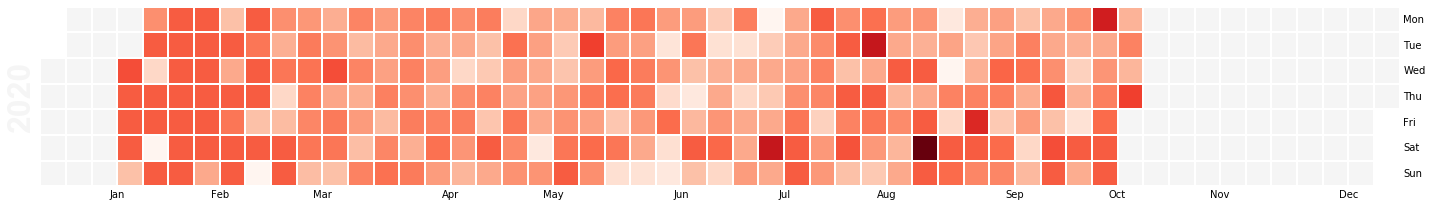

In [109]:
df1000["date"] = pd.to_datetime(df1000["date"])
avg_sentiment_per_day = df1000.groupby("date")['sentiment'].mean()
calmap.calendarplot(avg_sentiment_per_day, fig_kws=dict(figsize=(20, 20)))

In [117]:
df1000[df1000["date"]=='2020-08-09']

,type,sectionId,sectionName,webPublicationDate,webTitle,webUrl,apiUrl,fields,isHosted,pillarId,pillarName,trailText,title_subtitle,title_subtitle_bow,title_subtitle_lem,date,sentiment
id,,,,,,,,,,,,,,,,,
business/2020/aug/09/uk-to-fall-into-deepest-slump-on-record-with-worst-fall-in-gdp-among-g7,article,business,Business,2020-08-09T12:29:07Z,UK to plunge into deepest slump on record with...,https://www.theguardian.com/business/2020/aug/...,https://content.guardianapis.com/business/2020...,{'trailText': 'Official measure to be declared...,False,pillar/news,News,Official measure to be declared this week as c...,UK to plunge into deepest slump on record with...,uk to plunge into deepest slump on record with...,uk plunge deep slump record bad gdp drop g7 of...,2020-08-09,-0.4


### Transformers sentiment analysis